In [317]:
from io import StringIO
from dotenv import load_dotenv

import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns", 50)


In [318]:
aws_access_key_id = os.getenv("AWS_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

In [319]:
load_dotenv()

True

In [320]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """Downloads a csv file from an s3 bucket.
    
    Parameters
    ----------
    bucket : str
        The bucket where the files at.
    path : str
        The folders to the file.
    filename : str
        Name of the file.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame of the Downloaded file.
    
    """
    s3 = boto3.client("s3", aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_key)
    
    full_path = f"{path}{filename}"
    
    object = s3.get_object(Bucket = bucket, Key = full_path)
    object = object["Body"].read().decode("utf-8")
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [321]:
s3 = boto3.client("s3", aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_key)
bucket = "cubix-chicago-taxi-vti"

community_areas_path = "transformed_data/community_areas/"
company_path = "transformed_data/company/"
date_path = "transformed_data/date/"
payment_type_path = "transformed_data/payment_type/"
taxi_trips_path = "transformed_data/taxi_trips/"
weather_path = "transformed_data/weather/"



In [322]:
community_areas = read_csv_from_s3(bucket, community_areas_path, "community_areas_master.csv")
company = read_csv_from_s3(bucket, company_path, "company_master.csv")
date = read_csv_from_s3(bucket, date_path, "date_dimension.csv")
payment_type = read_csv_from_s3(bucket = bucket, path = payment_type_path, filename = "payment_type_master.csv")

In [323]:
trips_list = []
weather_list = []

In [324]:

for file in s3.list_objects(Bucket = bucket, Prefix = taxi_trips_path)["Contents"]:
    taxi_trip_key = file["Key"]
    
    if taxi_trip_key.split("/") [-1].strip() != "":
        if taxi_trip_key.split(".")[1] == "csv":
            
            filename =  taxi_trip_key.split("/") [-1]
            trip = read_csv_from_s3(bucket, taxi_trips_path, filename)

            trips_list.append(trip)
            print(f"{filename} has been added.")

          
                        

taxi_2024-06-22.csv has been added.
taxi_2024-06-23.csv has been added.
taxi_2024-06-24.csv has been added.
taxi_2024-06-25.csv has been added.
taxi_2024-06-26.csv has been added.
taxi_2024-06-27.csv has been added.
taxi_2024-06-28.csv has been added.
taxi_2024-07-01.csv has been added.


In [325]:
trips = pd.concat(trips_list, ignore_index = True)

In [326]:
trips.shape

(132228, 20)

In [327]:

for file in s3.list_objects(Bucket = bucket, Prefix = weather_path)["Contents"]:
    
    weather_key = file["Key"]
    
    if weather_key.split("/") [-1].strip() != "":
        if weather_key.split(".")[1] == "csv":
        
            filename = weather_key.split("/") [-1]

            weather_daily = read_csv_from_s3(bucket, weather_path, filename)

            weather_list.append(weather_daily)
            print(f"{filename} has been added.")



weather_2024-06-06.csv has been added.
weather_2024-06-07.csv has been added.
weather_2024-06-08.csv has been added.
weather_2024-06-09.csv has been added.
weather_2024-06-10.csv has been added.
weather_2024-06-11.csv has been added.
weather_2024-06-12.csv has been added.
weather_2024-06-13.csv has been added.
weather_2024-06-14.csv has been added.
weather_2024-06-15.csv has been added.
weather_2024-06-16.csv has been added.
weather_2024-06-17.csv has been added.
weather_2024-06-18.csv has been added.
weather_2024-06-19.csv has been added.
weather_2024-06-20.csv has been added.
weather_2024-06-21.csv has been added.
weather_2024-06-22.csv has been added.
weather_2024-06-23.csv has been added.
weather_2024-06-24.csv has been added.
weather_2024-06-25.csv has been added.
weather_2024-06-26.csv has been added.
weather_2024-06-27.csv has been added.
weather_2024-06-28.csv has been added.


In [328]:
weather = pd.concat(weather_list, ignore_index = True)

In [329]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       552 non-null    object 
 1   temperature    552 non-null    float64
 2   wind_speed     552 non-null    float64
 3   rain           552 non-null    float64
 4   precipitation  552 non-null    float64
dtypes: float64(4), object(1)
memory usage: 21.7+ KB


#### Join them together

In [330]:
trips_full = pd.merge(trips, weather, left_on="datetime_for_weather", right_on="datetime", how ="inner")
trips_full = trips_full.drop(columns=["datetime"])

In [331]:
trips_full = pd.merge(trips_full, company, left_on="company_id", right_on="company_id", how ="inner")
trips_full = trips_full.drop(columns=["company_id"])

In [332]:
trips_full = pd.merge(trips_full, payment_type, left_on="payment_type_id", right_on="payment_type_id", how ="inner")
trips_full = trips_full.drop(columns=["payment_type_id"])

In [333]:
trips_full = pd.merge(trips_full, community_areas, left_on="pickup_community_area_id", right_on="area_code", how ="inner")
trips_full = trips_full.drop(columns=["pickup_community_area_id", "area_code"])
trips_full.rename(columns={"community_name": "pickup_community_area_name"}, inplace=True)

In [334]:
trips_full = pd.merge(trips_full, community_areas, left_on="dropoff_community_area_id", right_on="area_code", how ="inner")
trips_full = trips_full.drop(columns=["dropoff_community_area_id", "area_code"])
trips_full.rename(columns={"community_name": "dropoff_community_area_name"}, inplace=True)

In [335]:
date["date"] = pd.to_datetime(date["date"])
trips_full["trip_start_timestamp"] = pd.to_datetime(trips_full["trip_start_timestamp"])

trips_full["trip_start_date"] = trips_full["trip_start_timestamp"].dt.date
trips_full["trip_start_date"] =pd.to_datetime(trips_full["trip_start_date"])

In [336]:
trips_full = pd.merge(trips_full, date, left_on="trip_start_date", right_on="date", how ="inner")
trips_full = trips_full.drop(columns=["date"])

In [337]:
trips_full.sample(4)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,day_of_week,is_weekend
10900,747c8c0d0bb281b40bab0442801073a23904388c,483961cb0205d5930cc7034607712e042be14ee82a20f0...,2024-06-22 12:15:00,2024-06-22T12:15:00.000,379,1.05,6.50,3.00,0.0,0.0,10.00,41.890922,-87.618868,41.900266,-87.632109,2024-06-22 12:00:00,26.0,16.0,0.0,0.0,Taxicab Insurance Agency Llc,Credit Card,Near North Side,Near North Side,2024-06-22,2024,6,22,6,True
34052,47df53a3c75fef3fc10d5932c79c7ebe36451357,11d27841ca91177af186bee8a9fdd7a2ead81b3fc96e1b...,2024-06-24 20:00:00,2024-06-24T20:15:00.000,367,0.99,6.25,0.00,0.0,0.0,6.25,41.892508,-87.626215,41.879255,-87.642649,2024-06-24 20:00:00,26.5,21.4,0.0,0.0,Globe Taxi,Cash,Near North Side,Near West Side,2024-06-24,2024,6,24,1,False
121649,095774dbe3be7a48b3d7ddb55911718049618a1f,de42f8191f3b8079c680589098c5f3f6e2d202e98f8a81...,2024-06-28 14:45:00,2024-06-28T15:30:00.000,2820,0.00,36.50,10.25,0.0,4.0,50.75,41.980264,-87.913625,41.944227,-87.655998,2024-06-28 14:00:00,19.5,20.3,2.4,2.4,"Taxicab Insurance Agency, LLC",Credit Card,O'Hare,Lake View,2024-06-28,2024,6,28,5,False
102498,3fef4ea094b9992fa33260dc284516818710cd30,46f364b8f1c2dc94a70735f2cf9074d94f4c71f2ff0917...,2024-06-27 14:45:00,2024-06-27T15:30:00.000,2183,12.57,34.75,9.81,0.0,4.0,49.06,41.785999,-87.750934,41.891972,-87.612945,2024-06-27 14:00:00,18.4,24.8,0.0,0.0,City Service,Credit Card,Garfield Ridge,Near North Side,2024-06-27,2024,6,27,4,False


#### Visualizations

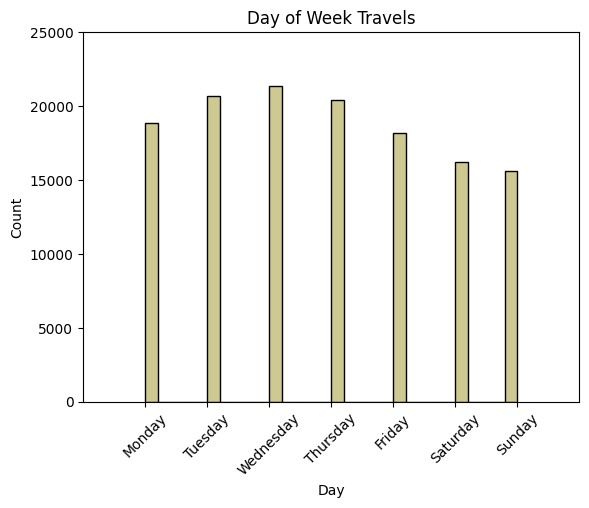

In [338]:
# 1. table Histogram of trips in a week

plot = sns.histplot(trips_full["day_of_week"], color="darkkhaki", bins= 30, kde= False)
plt.title("Day of Week Travels")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xlim(0, 8)
plt.ylim(0, 25000)

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.xticks(range(1, 8), day_names)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()

C:\Users\vtama\AppData\Local\Temp\ipykernel_13536\349002754.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


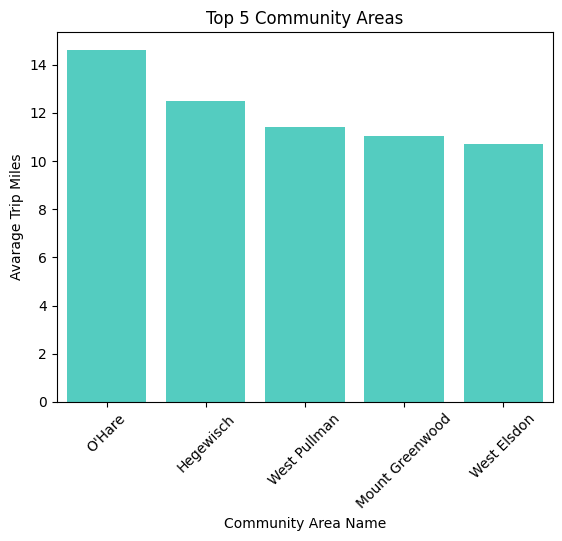

In [339]:
# 2.table Avarage trip miles by top 5 community area

ordered_trips = trips_full.groupby("pickup_community_area_name")["trip_miles"].mean().sort_values(ascending=False)

top_5_areas = ordered_trips.head(5)

plot = sns.barplot(x=top_5_areas.index, y=top_5_areas.values, color= "turquoise")
plt.title("Top 5 Community Areas")
plt.xlabel("Community Area Name")
plt.ylabel("Avarage Trip Miles")

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()

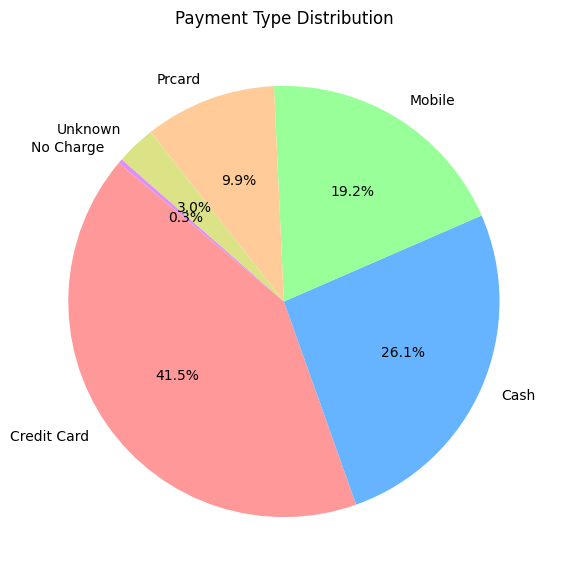

In [340]:
# 3.table Pie chart of payment types

data = trips_full["payment_type"].value_counts()
data = data[data.index != "Dispute"]

colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99","#dbe386","#dd90f5"]


plt.figure(figsize=(7, 7))
plt.pie(data, labels=data.index, autopct="%1.1f%%", startangle=140, colors=colors)


plt.title("Payment Type Distribution")
plt.show()

C:\Users\vtama\AppData\Local\Temp\ipykernel_13536\3692017301.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


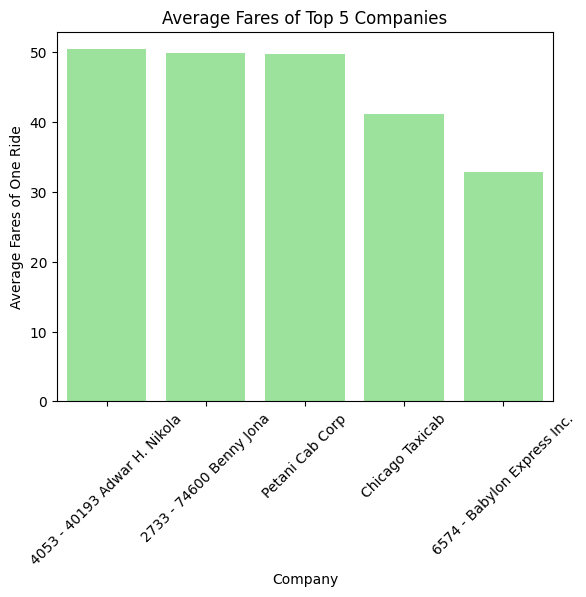

In [341]:
# 4. table Bar chart of top 3 companies and their average fees of rides.

ordered_fares = trips_full.groupby("company")["trip_total"].mean().sort_values(ascending=False)

top_5_companies = ordered_fares.head(5)

plot = sns.barplot(x=top_5_companies.index, y=top_5_companies.values, color="lightgreen")
plt.title("Average Fares of Top 5 Companies")
plt.xlabel("Company")
plt.ylabel("Average Fares of One Ride")

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()

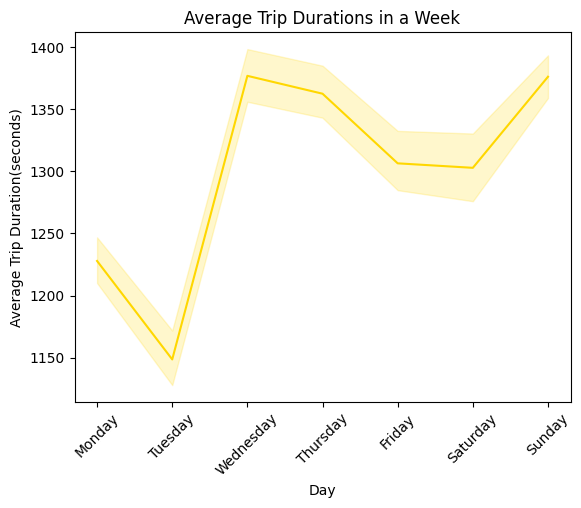

In [342]:
# 5. table trip seconds of a day

plot = sns.lineplot(x="day_of_week", y= "trip_seconds", data= trips_full, color= "gold")
plt.title("Average Trip Durations in a Week")
plt.xlabel("Day")
plt.ylabel("Average Trip Duration(seconds)")

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.xticks(range(1, 8), day_names)

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plt.show()